In [2]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
# from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
# from keras.utils import np_utils
# from skimage.transform import resize   # for resizing images
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import random as rnd
from glob import glob
from tqdm import tqdm
import os

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
device='cuda:0'

from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.integrate import tplquad
from scipy.ndimage import rotate as scipy_rotate
from scipy.ndimage import shift as scipy_shift
from joblib import Parallel, delayed

# Load Weizmann Data

In [3]:
datadir = "/home/ephy/Projects/tda_convolve_video/data/original/weizman/"

In [4]:
classes = os.listdir(datadir)

In [5]:
videos = []
y = []
for c in classes:
    d = os.listdir(datadir + c)
    for f in d:
        y.append(c)
        videos.append(f)
weizmann_labels=np.array(y)

In [6]:
imageSize=np.array([90,60])
videos = [(videos[i],y[i]) for i in range(len(y))]

In [7]:
weiz_image=np.load('/home/ephy/Projects/tda_convolve_video/data/altered/weizmann_FFR_23frames.npy', allow_pickle=True)
weizmann_labels = np.array(pd.get_dummies(weizmann_labels))

In [9]:
datadir = "/home/ephy/Projects/tda_convolve_video/data/original/KTH/"
classes = os.listdir(datadir)
classes = [c for c in classes if c!='scenes.txt']
f = open(datadir+'scenes.txt', "r")
scenes = []
for x in f:
    if '-' in x:
        parts = x.split('\t')
        name = parts[0].strip()+'_uncomp.avi'
        parts = parts[-1] 
        parts = parts.split(', ')
        starts = [part.split('-')[0] for part in parts]
        starts = np.array(starts, dtype=np.int)
        scenes.append((name,starts))
videos = []
y = []
for c in classes:
    d = os.listdir(datadir + c)
    for f in d:
        y.append(c)
        videos.append(f)
labels=np.array(y)
labels = np.repeat(labels, [len(scene[1]) for scene in scenes])
ds = [scene[0].split('_')[2] for scene in scenes for s in scene[1]]
len(ds)
persons = [scene[0].split('_')[0] for scene in scenes for s in scene[1]]
# nums = [str(i) for scene in scenes for i in range(len(scene[1]))]
stratLabels = [lab+d+person for (lab,d,person) in zip(labels,ds,persons)]
videos = [(videos[i],y[i]) for i in range(len(y))]
kth_image=np.load('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_FFR_23frames.npy', allow_pickle=True)

In [10]:
kth_to_weizmann_d ={
    'handwaving':'wave2',
    'running':'run',
    'walking':'walk'
}
kth_gen_labels = [kth_to_weizmann_d[label] if label in kth_to_weizmann_d.keys() else None for label in labels]
i,l,s = zip(*[(vid,label,stratLabel) for vid, label, stratLabel in zip(kth_image,kth_gen_labels,stratLabels) if label is not None])
kth_image = np.array(i)
kth_labels = np.array(pd.get_dummies(np.array(l)))
stratLabels = np.array(pd.get_dummies(np.array(s)))

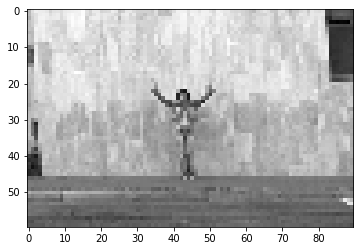

In [26]:
plt.imshow(weiz_image[np.where(np.all(weizmann_labels==np.unique(weizmann_labels,axis=0)[0],axis=1))[0][0]][12],cmap='gray')

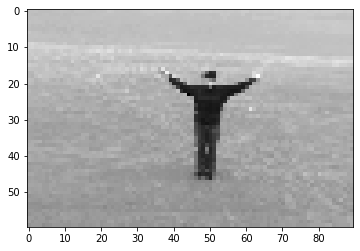

In [25]:
plt.imshow(kth_image[np.where(np.all(kth_labels==np.unique(kth_labels,axis=0)[0],axis=1))[0][0]][12],cmap='gray')

400
9
399
10
398
10


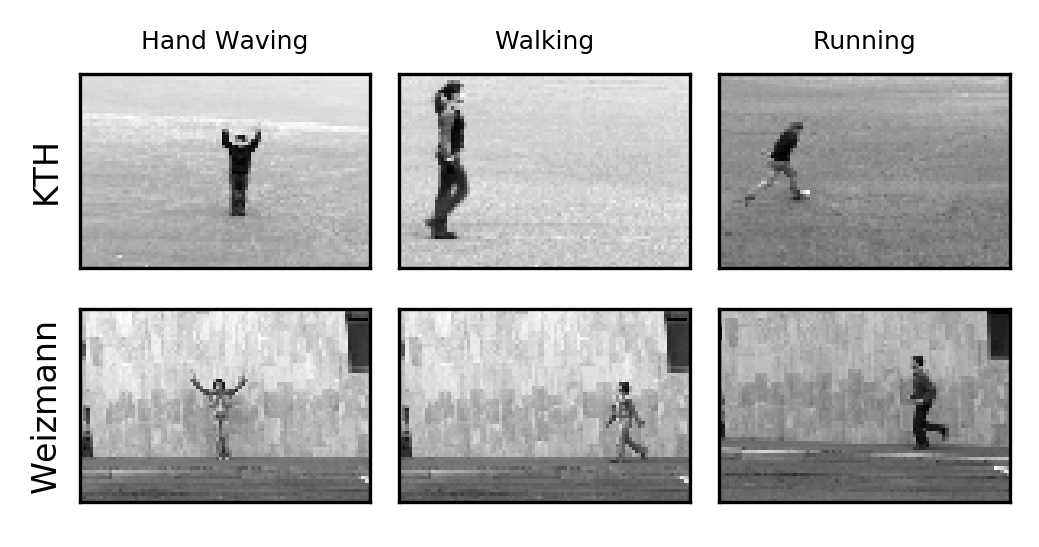

In [77]:
fig, axes = plt.subplots(2,3,figsize=(4.,4.), dpi=300)
for i in range(3):
    axes[0,i].imshow(kth_image[np.where(np.all(kth_labels==np.unique(kth_labels,axis=0)[i],axis=1))[0][0]][18],cmap='gray')
    print(np.sum(np.all(kth_labels==np.unique(kth_labels,axis=0)[i],axis=1)))
    axes[1,i].imshow(weiz_image[np.where(np.all(weizmann_labels==np.unique(weizmann_labels,axis=0)[i],axis=1))[0][0]][12],cmap='gray')
    print(np.sum(np.all(weizmann_labels==np.unique(weizmann_labels,axis=0)[i],axis=1)))
axes[0,0].set_title('Hand Waving',size=6)
axes[0,1].set_title('Walking',size=6)
axes[0,2].set_title('Running',size=6)
axes[0,0].set_ylabel('KTH',size=8)
axes[1,0].set_ylabel('Weizmann',size=8)
plt.subplots_adjust(wspace=.1,hspace=-.65)
plt.setp(axes, xticks=[], yticks=[])
plt.show()